# Fishing the Phish
*Integrative Team Project - IS Team 16 AY22*

# **1. Objective**
Phishing attack is one of the most common cyber attacks. Today phishing attackers use
software kits, called phishing kits, that provide ready-to-deploy packages. With the availability
of such kits, attackers need not any more require sophisticated technical knowledge or skills.
In this project, we plan to analyze hundreds of kits in a semi-automated or automated way, so
as to understand the underlying characteristics of phishing, the commonality across different
targets being phished, the evolution of the code base (and hence the attack), cloaking
techniques in use, etc.

# **2. Methodology**
The general idea of the project was to perform n-gram extraction of the source codes of phishing websites with [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) Vectorization, then with KMeans, cluster those phishing websites based on the n-grams extracted.

By saving the pre-fitted KMeans Model used to perform clustering, we are able to then also predict the clusters of new phishing websites, without having to re-fit the KMeans model.

# **3. Collecting the Data**
For this project, the team needed to obtain a significant amount of phishing kits and their source codes.

The team obtained all of the 600+ phishing kits used for this project from [phishunt.io](phishunt.io)'s repository of phishing kits, which is available on [GitHub](https://github.com/0xDanielLopez/phishing_kits)

The CSV and pickles used in this notebook can be obtained from the project's [Google Drive](https://drive.google.com/drive/folders/1ItSFvYVwbW8JXj4sb6OJ3o8n1AVpA6VS?usp=sharing)

Ensure that the files are placed in file paths as shown below.
To download:

**CSV**
1. csvs/combined_data.csv

**!!! NOTE: The following are only required if skipping to Step 6 !!!**

**CSV**
1. csvs/combined_data.csv
2. csvs/clustered.csv 

**Pickles**
1. pickles/tfidf_vocab.pkl
2. pickles/kmeans_prefitted.pkl

# **3.1. Pre-requisites**
Ensure the above. 

Installing the required python libraries.

In [ ]:
!pip install -r https://raw.githubusercontent.com/JustAyce/ITPTEAM16/main/requirements.txt

# **4. Creating the corpus**
The creation of the corpus was performed programmatically. In this process, the contents of each website's html, php files are concatenated to form its individual corpus, which are then stored into a chronologically sorted csv.

**Please don't run this, unless you plan to generate a new csv with different phishing kits.**

In [ ]:
# Importing the required libraries
import pandas as pd
import os.path
import os
import csv
import re
from pathlib import Path

In [ ]:
"""
User-provided Variables

    1. start_dir
        This is the absolute path where the phishing kits are stored.
        NOTE: Ensure that phishing kits have been unzipped!

    2. export_fp
        This is the file path where you want the output csv to be stored at.
        NOTE: (including file name!)

    3. header
        This defines the columns of the output csv.

    4. exclude
        This variable determines the list of directories to ignore.

    5. file_exts_to_concat
        This variable determines what files should be stored into the corpus.
    
    6. removal_list
        This variable determines the list of strings to be removed. 
    
    7. month_abbr
        A dictionary mapping for month abbreviations to its numerical form.
        NOTE: You do not need to touch this.
"""

# Change PWD of Script
start_dir = "/home/user/Desktop/Phishing_Kits"
os.chdir(start_dir)

# Define CSV Filename
export_fp = 'combined_data.csv'

# Define Columns of CSV
header = ['date', 'month', 'website', 'website_dirname', 'website_fp', 'content']

# List of directories to ignore
exclude = set(['__MACOSX'])

# File Extensions to Concat
file_exts_to_concat = ('.html', '.php')

# Strings to remove
removal_list = ['\t', '\n']

# Monthly Abbreviations to convert month abbreviations to numerical form
month_abbr = {
    "Jan": 1, "Feb": 2, "Mar": 3, "Apr": 4,
    "May": 5, "Jun": 6, "Jul": 7, "Aug": 8,
    "Sep": 9, "Oct": 10, "Nov": 11, "Dec": 11
    }

In [ ]:
def create_source_code_corpus():
    with open(export_fp, 'w', newline='') as f:
        writer = csv.writer(f, delimiter=',', quoting=csv.QUOTE_ALL, quotechar='"', escapechar='\\')
        writer.writerow(header)

        years = next(os.walk('.'))[1]
        for year in years:
            year_dir = os.path.join('.', year)
            months = next(os.walk(year_dir))[1]
            for month in months:
                month_dir = os.path.join(year_dir, month)
                websites = next(os.walk(month_dir))[1]
                for index, website in enumerate(websites):
                    # Remove (.?.zip)
                    website_url = os.path.basename(website).split(" ",1)[0]

                    website_fp = os.path.join(month_dir, website)

                    # Split "Month" (e.g. Jan_2022) into an actual date (e.g. 2022-01-01)  
                    # so that the csv is easily sortable by date
                    # format:
                    # "2022-01-01"
                    month_year = month.split("_")
                    converted_date = f"{month_year[1]}-{month_abbr[month_year[0]]:02d}-01"

                    row = [converted_date, month, website_url, website, website_fp, '']

                    for root, dirs, files in os.walk(website_fp, topdown=True):
                        dirs[:] = [d for d in dirs if d not in exclude]
                        for file in files:
                            if file.endswith(file_exts_to_concat):
                                txt = Path(os.path.join(root, file)).read_text(errors='ignore')
                                for to_remove in removal_list:
                                    txt = txt.replace(to_remove,'')
                                txt = re.sub("<style.*>.*<\/style>","", txt)
                                row[5] += txt

                    writer.writerow(row)

        # Sort the csv by date
        df = pd.read_csv(export_fp, index_col = False)
        df['date'] = pd.to_datetime(df['date']).dt.strftime('%y-%m-%d')
        df.sort_values(['date', 'website'], inplace=True)
        df.to_csv(export_fp, index=False)

In [ ]:
# Run the corpus creation function
create_source_code_corpus()

# **5. Clustering**
The purpose of this stage is to obtain clustering labels for the phishing websites.


In this stage, the process is as follows:
1. Load the corpus
   
2. The corpus is transformed by [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) into a matrix of n-grams.

3. With the transformed corpus, the ideal number of clusters (k=n) is obtained with the [Elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)), before clustering the phishing websites with [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).

4. After clustering with [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html), [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) and [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) graphs are plotted to obtain a visualized representation of the clusters.

5. Cluster labels are stored into a csv.
   
6. [Pickle](https://docs.python.org/3/library/pickle.html) dump vocabulary of TfidfVectorizer, and fitted model of KMeans.

**Optional.** Users can choose to copy the phishing kits into another directory, organized by clusters. 

An example: /clusters/1/website.com. 

The purpose is to faciliate and smoothen the process of manually analyzing the clusters.

In [1]:
# Importing the required libraries
import os
from sklearn.cluster import KMeans
import csv

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import sys

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import pickle

In [ ]:
"""
Optional cell block.
To only be run when issues are encountered when displaying contents of a csv
"""
maxInt = sys.maxsize

while True:
    # decrease the maxInt value by factor 10 
    # as long as the OverflowError occurs.

    try:
        csv.field_size_limit(maxInt)
        break
    except OverflowError:
        maxInt = int(maxInt/10)
        
csv.field_size_limit(maxInt)

## **5.1: Loading the Corpus**
Here, the csv containing the corpus(es) is loaded.

In [2]:
csv_folder = r'csvs'
corpus_csv_filename = r'combined_data.csv'

df_corpus = pd.read_csv(os.path.join(csv_folder, corpus_csv_filename), sep=',', encoding="ISO-8859-1")
df_corpus = df_corpus.dropna(subset=['content'])

data = df_corpus['content']
data_split = np.array_split(data, 3)

for i in range(0, len(data_split)):
    data_split[i] = data_split[i].astype('U')

del data
data = np.concatenate((data_split[0], data_split[1], data_split[2]))

## **5.2.1. TF-IDF Vectorization**
Here, TF-IDF Vectorization is performed on the corpus(es), obtaining a matrix of n-grams.

In [3]:
# Initialize TfidfVectorizer
tfidf_vect = TfidfVectorizer(
    #token_pattern = '[a-zA-Z0-9]#$&+,:;=?@#|<>.^*()%!-]+',
    ngram_range=(5,7),
    max_df = 0.2,
    max_features = 1000
    )

# Fit the model with training data
tf_transformer = tfidf_vect.fit(data)

# Transform to obtain sparse matrix
tfidf_matrix = tfidf_vect.transform(data)

## **5.2.2. Visualize TF-IDF N-grams**
Here, the matrix is visualized into a more human-readable form.

In [4]:
tfidf_array = tfidf_matrix.toarray()
df = pd.DataFrame(data=tfidf_array,columns = tfidf_vect.get_feature_names_out())

df.head()

,0a 20 20 20 20,0a 20 20 20 20 20,0a 20 20 20 20 20 20,12 col sm 12 control,12 col sm 12 control label,12 col sm 12 control label label,12 control label label for,1404201901 amp ca1404201901 link rel,1404201901 amp ca1404201901 link rel prefetch,1404201901 amp ca1404201901 link rel prefetch href,...,www apple com la hreflang,www apple com la hreflang es,www apple com lae hreflang,www apple com lae hreflang en,www apple com us search,www apple com us shop,www apple com us shop goto,x20 x20 x20 x20 x20,x20 x20 x20 x20 x20 x20,x20 x20 x20 x20 x20 x20 x20
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## **5.3.1. Obtain ideal number of clusters (n=k) with Elbow Method**
With the [Elbow Method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)), we obtain the ideal number of clusters, k, to be used as input when clustering with KMeans.

In [5]:
# Optional: Suppress Future Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)  
warnings.simplefilter(action='ignore', category=UserWarning)


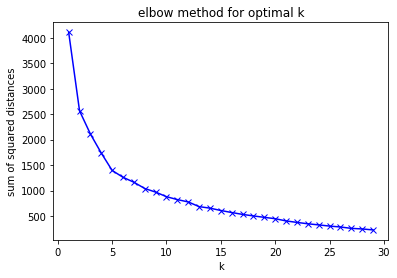

In [12]:
from sklearn.preprocessing import MinMaxScaler
def find_optimal_clusters(data, max_k):
    mms = MinMaxScaler()
    mms.fit(data)
    data_transformed = mms.transform(data)
    sum_of_squared_distances = []
    K = range(1, max_k)
    for k in K:
        km = KMeans(n_clusters=k)
        km = km.fit(data_transformed)
        sum_of_squared_distances.append(km.inertia_)
    
    plt.plot(K, sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('sum of squared distances')
    plt.title('elbow method for optimal k')    
    plt.show()

find_optimal_clusters(tfidf_matrix.todense(), 30)

## **5.3.2. Perform clustering with KMeans with n=k obtained from the elbow method**
**NOTE: Please replace number_of_clusters with the k value obtained from the elbow method**

In [13]:
# NOTE: Replace this variable with the k value obtained from the elbow method.
number_of_clusters = 14

_kmeans = KMeans(n_clusters=number_of_clusters)
labels = _kmeans.fit_predict(tfidf_matrix)

## **5.4. Plot PCA & t-SNE Graph**
Here, we plot out [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) and [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) graphs for a visualized representation of the clusters.

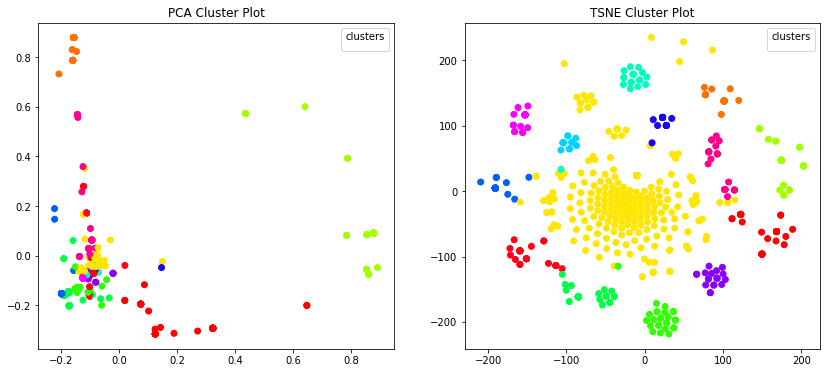

In [14]:
def plot_tsne_pca(data, labels):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=len(labels), replace=False)
    
    pca = PCA(n_components=2).fit_transform(data[max_items,:].todense())
    tsne = TSNE(init='pca', learning_rate='auto').fit_transform(
        PCA(n_components=50).fit_transform(data[max_items,:].todense())
        )
    
    idx = np.random.choice(range(pca.shape[0]), size=len(labels), replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))

    pca_s = ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].legend(*pca_s.legend_elements(),title='clusters')
    ax[0].set_title('PCA Cluster Plot')
    
    tsne_s = ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].legend(*tsne_s.legend_elements(),title='clusters')
    ax[1].set_title('TSNE Cluster Plot')
    
plot_tsne_pca(tfidf_matrix, labels)

## **5.5. Store cluster labels into csv**
The cluster labels are stored into a csv, which can be used for future prediction accuracy analysis.

In [17]:
csv_folder = r'csvs'
output_cluster_csv_fp = r'clustered.csv'

df_corpus['clusters'] = labels
df_corpus.to_csv(os.path.join(csv_folder, output_cluster_csv_fp), index=False)

## **5.6. Pickle Dump TF-IDF Vocabulary and Fitted KMeans Model**
Here, we pickle dump the TF-IDF Vocabulary and Fitted KMeans Model. 

With these dumped pickles, we are able to perform prediction on new corpus(es) without having to refit the KMeans Model. 

In [18]:
# NOTE: Replace these variables with desired file name.
pickle_directory = 'pickles'
tfidf_vocab_pickle_filename = r'tfidf_vocab.pkl' 
kmeans_prefitted_filename = r'kmeans_prefitted.pkl'

# Dump TF-IDF Vocab
pickle.dump(tf_transformer, open(os.path.join(pickle_directory, tfidf_vocab_pickle_filename), "wb"))

# Dump Prefitted KMeans model
pickle.dump(_kmeans, open(os.path.join(pickle_directory, kmeans_prefitted_filename), "wb"))

## **OPTIONAL: Copy Phishing Kits into another directory, organized by clusters**
This is an optional step whereby phishing kits are copied into another directory, organized by clusters.

 An example: /clusters/1/website.com. The purpose is to faciliate and smoothen the process of manually analyzing the clusters.

In [ ]:
import shutil

months = df_corpus['month']
websites_dirnames = df_corpus['website_dirname']
website_fp = df_corpus['website_fp']
if os.path.exists('clusters'):
    shutil.rmtree('clusters')

for i in range(len(labels)):
    cp_from_dir = website_fp[i]

    # e.g. clusters/1/Jan_2022_misaelrosetti.net
    cp_to_dir = os.path.join('clusters', str(labels[i]+1), f"{months[i]}_{websites_dirnames[i]}")
    
    shutil.copytree(cp_from_dir, cp_to_dir)

# **6. Cluster Prediction with a Pre-fitted KMeans Model**
The purpose of this stage is to predict the cluster of a new corpus (i.e., new phishing website), without re-fitting the KMeans model.

Here, we load the TF-IDF Vocabulary and the Pre-fitted KMeans Model obtained from the previous steps, to transform a new corpus and predict its cluster.

In this stage, the process is as follows:
1. Load the corpus

2. Load TF-IDF Vocabulary, Pre-fitted KMeans Model pickles
   
3. Transform the new corpus with the loaded TF-IDF Vocabulary into a matrix of n-grams

4. Predict the clusters of the corpus with the Pre-fitted KMeans Model

## **6.1. Load the corpus**
Here, the csv containing the corpus(es) is loaded.

In [19]:
# Importing the dataset
csv_folder = r'csvs'
clustered_csv_fp = r'clustered.csv'

dataset = pd.read_csv(os.path.join(csv_folder, clustered_csv_fp))
df = dataset['content']

## **6.2. Load TF-IDF Vocabulary, Pre-fitted KMeans Model pickles**

In [20]:
pickle_directory = 'pickles'
tfidf_vocab_pickle_filepath = r'tfidf_vocab.pkl' 
kmeans_prefitted_pickle_filepath = r'kmeans_prefitted.pkl'

# Load TF-IDF Vocabulary
tf_vocab_pkl = pickle.load(open(os.path.join(pickle_directory, tfidf_vocab_pickle_filepath), 'rb'))

# Load Prefitted KMeans model
kmeans_prefit_pkl = pickle.load(open(os.path.join(pickle_directory, kmeans_prefitted_pickle_filepath), "rb"))

## **6.3. TF-IDF Vectorization**
Here, TF-IDF Vectorization is performed on the corpus(es), obtaining a matrix of n-grams.

In [21]:
tf_vect = TfidfVectorizer(
    #token_pattern = '[a-zA-Z0-9]#$&+,:;=?@#|<>.^*()%!-]+',
    ngram_range=(5,7),
    max_df = 0.2,
    max_features = 1000,
    vocabulary = tf_vocab_pkl.vocabulary_
    )

pred_matrix = tf_vect.fit_transform(df)

## **6.4. Predict cluster labels of corpus**
Here, with the pre-fitted KMeans model, prediction is performed on the corpus(es), obtaining cluster labels (pred_labels).

In [22]:
pred_labels = kmeans_prefit_pkl.predict(pred_matrix)

pred_labels

array([ 2,  2,  3,  2, 11,  2,  0,  2,  2,  5,  2,  0,  2,  1,  0,  2,  2,
        6,  2,  2,  6,  2,  8,  2,  2,  4,  8,  6,  2,  2,  2,  0,  2,  2,
        2,  2,  2,  2,  2, 11,  2, 13,  8,  2,  2,  0, 11,  2,  2, 11,  5,
        0,  2,  6,  6,  0,  2,  2,  2, 11,  2,  1, 12,  2,  3,  2,  6,  2,
        0,  2,  2,  2,  2,  0,  2, 11,  2,  2, 11,  5,  2,  2,  2,  4, 12,
        2, 13,  5,  2,  2, 11,  3,  5,  2, 11,  3,  2,  2,  6,  2,  2,  2,
        2, 10, 11,  2, 12,  0, 10,  2,  2,  2,  2,  2,  3,  2,  2,  4,  7,
        7,  2,  2,  4,  5,  2,  0,  2,  2, 11,  2,  2,  2,  2, 10,  2,  2,
       11,  2,  8,  2,  6,  1,  4,  2,  2,  2,  2,  3,  2,  2,  2,  5,  2,
        6,  2,  6,  2,  2,  0,  8,  8,  2,  1, 13,  2,  2,  8,  7,  0,  2,
        2,  2, 12,  3,  2,  1, 13,  2,  4,  4,  8, 12,  1,  2,  9,  9,  1,
        8,  2,  2,  2, 13,  2,  2,  2,  5,  2,  2,  2,  9,  9,  2,  9, 12,
        9, 10,  2,  2,  2,  0,  2,  2,  0,  2, 13,  2,  2,  2, 11,  2, 13,
        4,  2,  2, 13,  8

# **7: Conclusion**

With this, the objective of this project is achieved. We are able to cluster and predict phishing kits with a reasonable degree of accuracy and timespan.

# **8: References**
* https://phishunt.io/
* https://github.com/0xDanielLopez/phishing_kits
* https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
* https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html


# **Defunct: Obtain Top Keywords of Each Cluster**

In [ ]:
import gc; gc.collect()

def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print('<TERM>', end='')
        print('\n<TERM>'.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
            
get_top_keywords(tfidf_matrix, labels, tfidf_vect.get_feature_names(), 10)